In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

In [2]:
df_1 = pd.read_csv("../data/Flight delays/flight_delays_train.csv")
df_2 = pd.read_csv("../data/Flight delays/flight_delays_test.csv")

In [3]:
df = pd.concat([df_1, df_2])

In [4]:
df_1.shape, df_2.shape, df.shape

((100000, 9), (100000, 8), (200000, 9))

In [5]:
df["month"] = df["Month"].str.replace("c-", "").astype(int)
df["WeekDay"] = df["DayOfWeek"].str.replace("c-", "").astype(int)
df["MonthDay"] = df["DayofMonth"].str.replace("c-", "").astype(int)

In [6]:
df["is_weekend"] = (df["WeekDay"] == 6) | (df["WeekDay"] == 7)

In [7]:
def categorize_dist(distance):
    if distance <= 1500:
        return "short-haul"
    elif 1500 < distance <= 3000:
        return "medium-haul"
    else:
        return "long_haul"

In [8]:
df["category"] = df["Distance"].apply(categorize_dist)

In [9]:
df["time"] = pd.to_datetime(df["DepTime"], format="%H%M", errors="coerce")

In [10]:
df['time'] = df["time"].fillna("00:00")

In [11]:
df["december_holidays"] = (df["month"] == 6) | (df["month"] ==7) | (df["month"] == 8)

In [12]:
df["time_of_day"] = df["time"].dt.hour

In [13]:
df.drop(["Month", "DayofMonth", "DayOfWeek", "DepTime", "time"], axis=1, inplace=True)

In [14]:
df.head()

,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,month,WeekDay,MonthDay,is_weekend,category,december_holidays,time_of_day
0,AA,ATL,DFW,732,N,8,7,21,True,short-haul,True,19
1,US,PIT,MCO,834,N,4,3,20,False,short-haul,False,15
2,XE,RDU,CLE,416,N,9,5,2,False,short-haul,False,14
3,OO,DEN,MEM,872,N,11,6,25,True,short-haul,False,10
4,WN,MDW,OMA,423,Y,10,6,7,True,short-haul,False,18


In [15]:
df["hour_sqrd"] = df["time_of_day"] ** 2
df["hour_sqrd_2"] = df["time_of_day"] ** 4

In [16]:
train_df = df[:100000]
test_df = df[100000:]

In [17]:
train_df["delayed"] = train_df["dep_delayed_15min"].map({"Y": 1, "N": 0})

C:\Users\Panache Branding\AppData\Local\Temp\ipykernel_9440\4232699012.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["delayed"] = train_df["dep_delayed_15min"].map({"Y": 1, "N": 0})


In [18]:
train_df.drop("dep_delayed_15min", axis=1, inplace=True)

C:\Users\Panache Branding\AppData\Local\Temp\ipykernel_9440\980255738.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop("dep_delayed_15min", axis=1, inplace=True)


In [19]:
X = train_df.drop("delayed", axis=1)
y = train_df["delayed"]

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [21]:
clf = CatBoostClassifier(iterations=3000, random_seed=17)

In [22]:
cat_idx = np.where(df.dtypes == "object")[0]

In [23]:
df.head()

,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,month,WeekDay,MonthDay,is_weekend,category,december_holidays,time_of_day,hour_sqrd,hour_sqrd_2
0,AA,ATL,DFW,732,N,8,7,21,True,short-haul,True,19,361,130321
1,US,PIT,MCO,834,N,4,3,20,False,short-haul,False,15,225,50625
2,XE,RDU,CLE,416,N,9,5,2,False,short-haul,False,14,196,38416
3,OO,DEN,MEM,872,N,11,6,25,True,short-haul,False,10,100,10000
4,WN,MDW,OMA,423,Y,10,6,7,True,short-haul,False,18,324,104976


In [24]:
clf.fit(X_train, y_train, cat_features=[0, 1, 2, 4,8, 9], plot=True, verbose=False);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [25]:
y_preds = clf.predict_proba(X_valid)[:, 1]

In [26]:
roc_auc_score(y_valid, y_preds)

0.7387520233211317

In [27]:
X.head()

,UniqueCarrier,Origin,Dest,Distance,month,WeekDay,MonthDay,is_weekend,category,december_holidays,time_of_day,hour_sqrd,hour_sqrd_2
0,AA,ATL,DFW,732,8,7,21,True,short-haul,True,19,361,130321
1,US,PIT,MCO,834,4,3,20,False,short-haul,False,15,225,50625
2,XE,RDU,CLE,416,9,5,2,False,short-haul,False,14,196,38416
3,OO,DEN,MEM,872,11,6,25,True,short-haul,False,10,100,10000
4,WN,MDW,OMA,423,10,6,7,True,short-haul,False,18,324,104976


In [28]:
feature_importance = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

In [29]:
len(feature_importance)

13

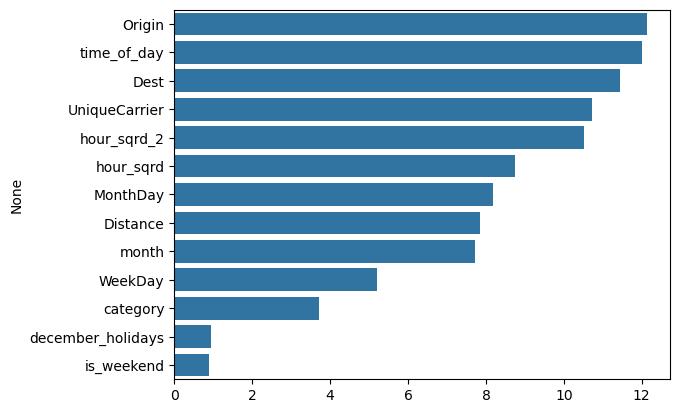

In [30]:
sns.barplot(x=feature_importance.values, y=feature_importance.index);

In [31]:
import optuna

In [32]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 1, 10),
        "border_count": trial.suggest_int("border_count", 32, 256)
    }
    
    clf = CatBoostClassifier(**params, verbose=False, cat_features=[0, 1, 2, 4,8, 9])
    clf.fit(X_train, y_train)
    y_preds = clf.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_preds)

In [33]:
study = optuna.create_study(direction="maximize")

[I 2024-08-30 15:01:52,775] A new study created in memory with name: no-name-eba15a7f-8098-4340-8246-693fa2529272


In [34]:
study.optimize(objective, n_jobs=-1, n_trials=20, show_progress_bar=True)

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-08-30 15:04:01,339] Trial 0 finished with value: 0.7350988880885417 and parameters: {'iterations': 737, 'learning_rate': 0.03565758315075242, 'depth': 7, 'l2_leaf_reg': 5.384942724442144, 'random_strength': 9, 'bagging_temperature': 5.876293146244058, 'border_count': 78}. Best is trial 0 with value: 0.7350988880885417.
[I 2024-08-30 15:06:14,089] Trial 2 finished with value: 0.7369707082381654 and parameters: {'iterations': 1827, 'learning_rate': 0.02606023533035577, 'depth': 5, 'l2_leaf_reg': 2.1976880005950656, 'random_strength': 2, 'bagging_temperature': 9.213765155401179, 'border_count': 104}. Best is trial 2 with value: 0.7369707082381654.
[I 2024-08-30 15:06:32,350] Trial 1 finished with value: 0.73973485887768 and parameters: {'iterations': 1637, 'learning_rate': 0.05789692448240518, 'depth': 6, 'l2_leaf_reg': 4.6015981700902024, 'random_strength': 2, 'bagging_temperature': 6.526125173960081, 'border_count': 187}. Best is trial 1 with value: 0.73973485887768.
[I 2024-08-

In [35]:
study.best_params

{'iterations': 1874,
 'learning_rate': 0.030918802363867737,
 'depth': 7,
 'l2_leaf_reg': 3.1544301038203555,
 'random_strength': 4,
 'bagging_temperature': 4.379209727296892,
 'border_count': 182}

In [36]:
study.best_value

0.7405343118870072

In [37]:
clf = CatBoostClassifier(**study.best_params, verbose=False, cat_features=[0, 1, 2, 4,8, 9])

In [38]:
clf.fit(X_train, y_train, verbose=False, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [39]:
test_df.head()

,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,month,WeekDay,MonthDay,is_weekend,category,december_holidays,time_of_day,hour_sqrd,hour_sqrd_2
0,YV,MRY,PHX,598,NaN,7,3,25,False,short-haul,True,6,36,1296
1,WN,LAS,HOU,1235,NaN,4,2,17,False,short-haul,False,7,49,2401
2,MQ,GSP,ORD,577,NaN,12,7,2,True,short-haul,False,6,36,1296
3,WN,BWI,MHT,377,NaN,3,7,25,True,short-haul,False,16,256,65536
4,UA,ORD,STL,258,NaN,6,3,6,False,short-haul,True,15,225,50625


In [40]:
set(train_df) - set(test_df)

{'delayed'}

In [41]:
test_df.drop("dep_delayed_15min", axis=1, inplace=True)

C:\Users\Panache Branding\AppData\Local\Temp\ipykernel_9440\324328343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop("dep_delayed_15min", axis=1, inplace=True)


In [42]:
y_preds = clf.predict_proba(test_df)[:, 1]

In [43]:
submission_df = pd.DataFrame({"id": range(len(y_preds)), "dep_delayed_15min": y_preds})

In [44]:
submission_df.to_csv("submission_2.csv", index=False)

In [45]:
len(submission_df)

100000